In [336]:
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm

In [2]:
import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner

## Construct configs

## Load things

In [378]:
# Load data
basedir = '/Users/maho/git/ltu-ili'
# basedir = '/home/mattho/git/ltu-ili'

cfgdir = basedir+'/paper/2_toy'
wdir = basedir+'/paper/wdir/toy'
imdir = basedir+'/paper/images'

os.chdir(cfgdir)

In [400]:
all_loader = SBISimulator.from_config(join(cfgdir, "data_train.yaml"))
x, theta = all_loader.get_all_data(), all_loader.get_all_parameters()

x_obs = np.load(join(wdir, 'x_obs.npy'))
theta_obs = np.load(join(wdir, 'theta_obs.npy'))[0]
ndim = theta_obs.shape[0]
print(theta_obs)

samples = {}
summaries = {}
models = ['SNPE']#, 'SNLE', 'SNRE', 'pydelfi']
for m in models:
    samples[m] = np.load(join(wdir, f'toy_{m}_single_samples.npy'))
    filename = join(wdir, f'toy_{m}_summary_1.json')
    summaries[m] = pd.read_json(filename)

[0.412 0.67  0.39 ]


In [401]:
# Load hmc
hmc_samples = np.load(join(wdir, 'hmc_samples.npy'))

[-543.8402    -329.45834   -170.38959    -59.73861     -6.556605
   -5.4425273  -58.347404  -166.67665   -326.7749    -544.27966  ]
[93.99168   58.723385  29.07478    9.081996   6.799894   7.2583256
  8.051663  26.433203  55.286583  93.00319  ]


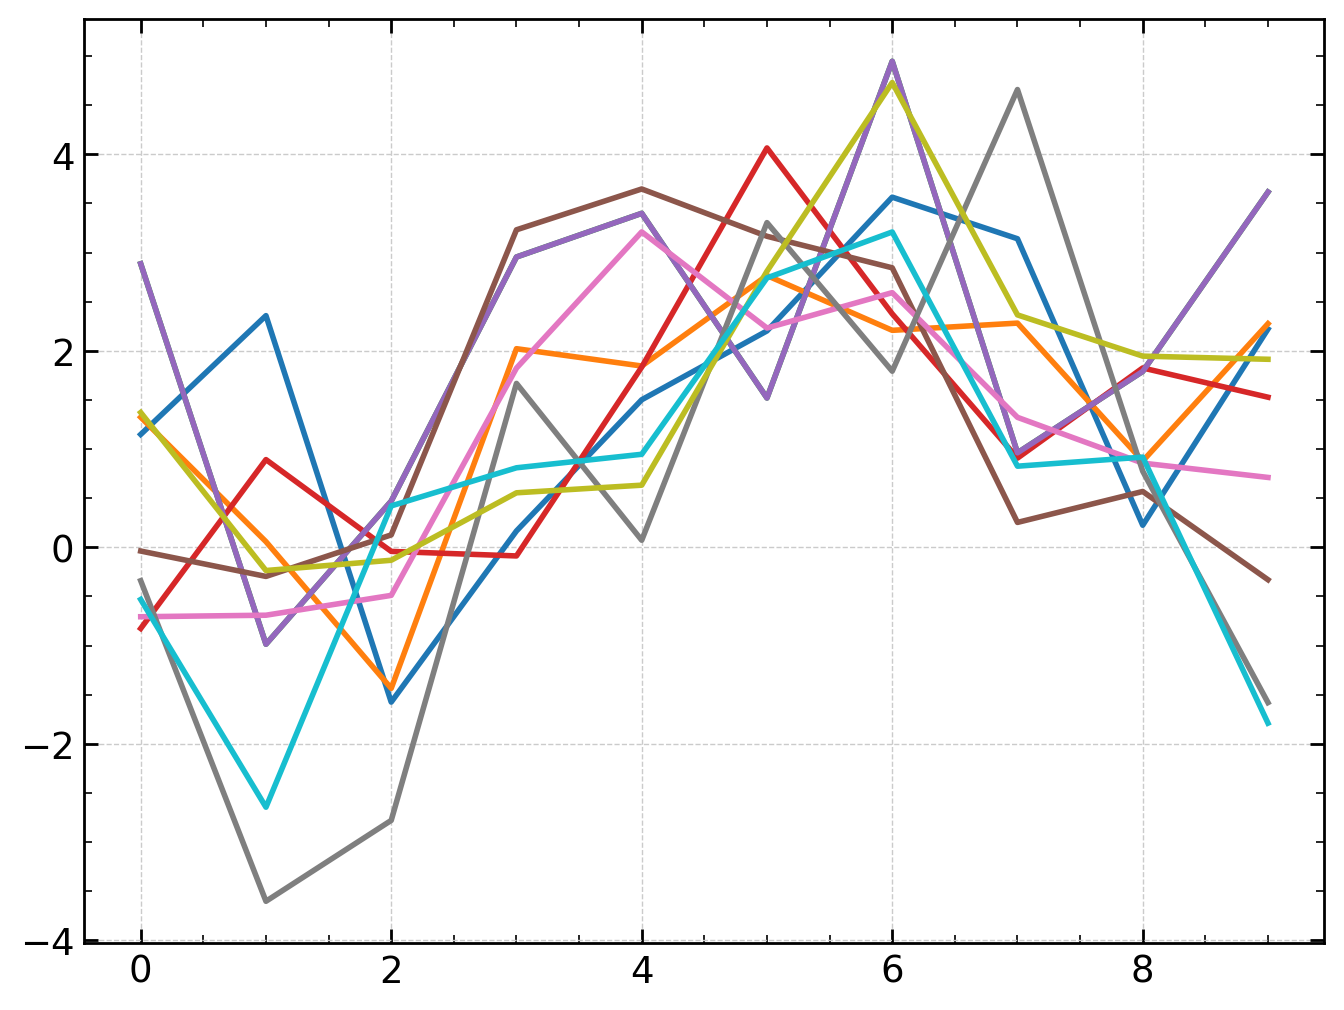

In [402]:
fig, ax = plt.subplots()
for j in np.random.choice(len(x), 10):
    ax.plot(x[j])

print(x.min(axis=0))
print(x.max(axis=0))

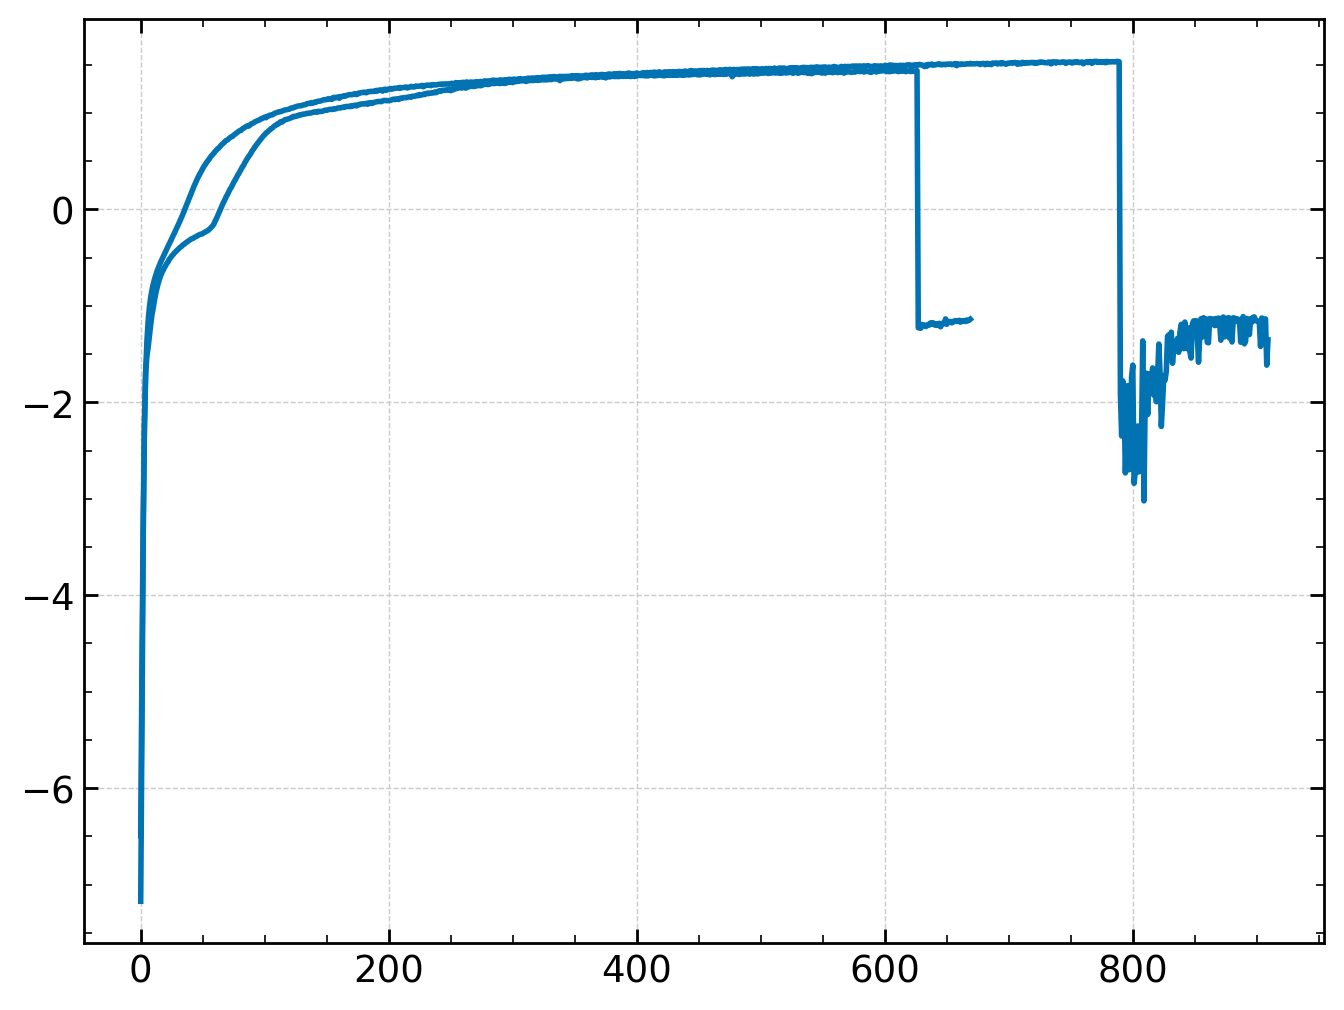

In [403]:
# plot loss
colors = sns.color_palette('colorblind')

fig, ax = plt.subplots()
for j, m in enumerate(models):
    for i in range(len(summaries[m])):
        ax.plot(summaries[m].loc[i, 'validation_log_probs'], 
                label=m, color=colors[j])

## Comparison

In [387]:
cols = [f"$\\theta_{i}$" for i in range(3)]
sampdf = [
    pd.DataFrame(samples[m], columns=cols)
    for m in models
]
modelnames = [f'sbi-{x}' for x in ['NPE', 'NLE', 'NRE']]
modelnames += [r'pydelfi-NLE']
for i in range(len(models)):
    sampdf[i]['Toy Model'] = modelnames[i]
sampdf = pd.concat(sampdf)

In [388]:
def pairplot(samples, axs, theta_obs, color, label, truth=False, **kwargs):
    lims = [[-0.75,1.25], [0,2], [-1, 1]]
    for i in range(ndim):
        for j in range(ndim):
            if i == j:
                axs[i, j].axvline(theta_obs[i], lw=2, color="r",
                                  label="Truth" if truth else None)
                sns.kdeplot(samples[:, i], ax=axs[i, j], fill=False, 
                            color=color,
                            common_norm=True, linewidth=2, label=label)
                axs[i, j].set_xlim(*lims[j])
                axs[i, j].yaxis.set_visible(False)  # Turn off y-axis
            elif i > j:
                df_ = pd.DataFrame(samples[:, [j, i]], 
                                   columns=[f'$\\theta_{j}$', f'$\\theta_{i}$'])
                sns.kdeplot(data=df_, x=f'$\\theta_{j}$', y=f'$\\theta_{i}$',
                            ax=axs[i, j], levels=[0.1, .36, 1],
                            color=color, common_norm=True,
                            **kwargs)
                axs[i, j].axhline(theta_obs[i], lw=2, color="r")
                axs[i, j].axvline(theta_obs[j], lw=2, color="r")
                axs[i, j].plot(theta_obs[j], theta_obs[i], "ro")
                axs[i,j].set_xticks(np.arange(-3,3, 0.5))
                axs[i,j].set_yticks(np.arange(-3,3, 0.5))
                axs[i, j].set_xlim(*lims[j])
                axs[i, j].set_ylim(*lims[i])
                # ticks = [f"{x:.0g}" for x in ticks]
                # axs[i,j].set_xticklabels(ticks)
                # axs[i,j].set_yticklabels(ticks)
            else:
                axs[i, j].axis('off')
            if (i==ndim-1) and (j==ndim-1):
                axs[i, j].set_xlabel(f'$\\theta_{j}$')
            if (j!=0):
                axs[i, j].set_ylabel('')
                axs[i, j].set_yticklabels([])

In [404]:
# Load again
hmc_samples = np.load(join(wdir, 'hmc_samples.npy'))
m = 'SNPE'
samples[m] = np.load(join(wdir, f'toy_{m}_single_samples.npy'))

import pickle
m = 'abc'
with open(join(wdir, 'toy_abc_samples.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)

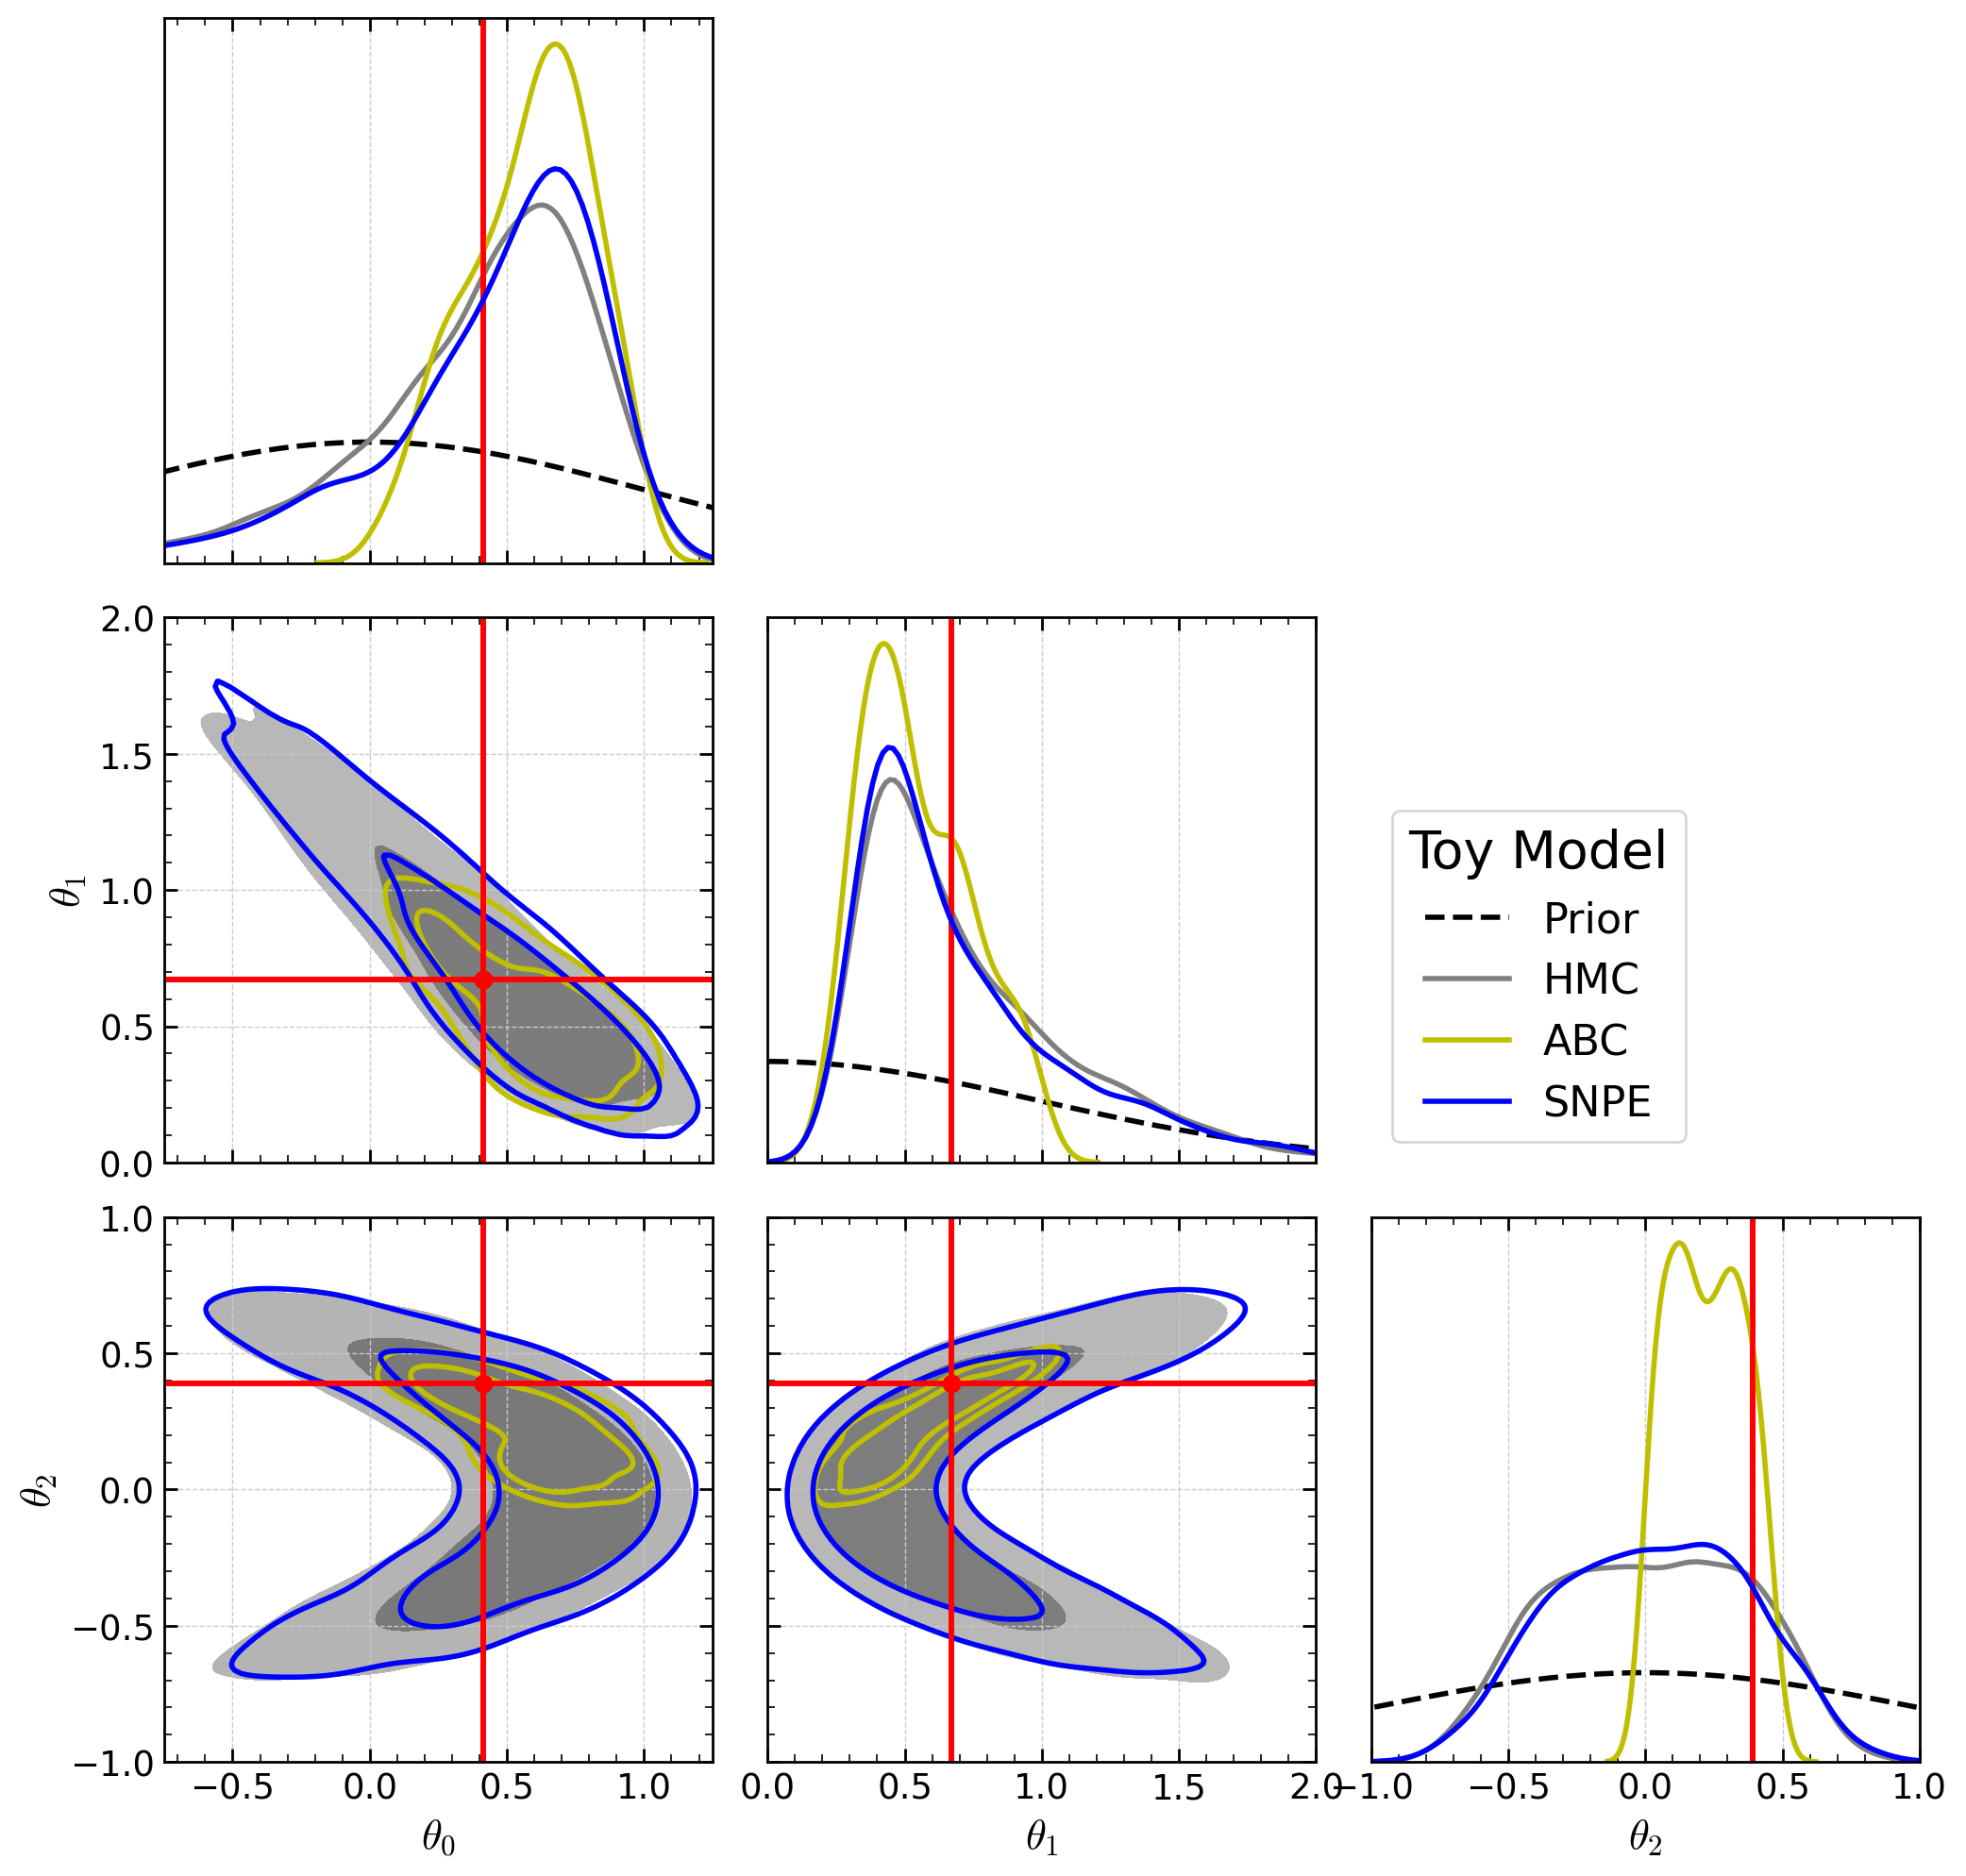

In [405]:
fig, axs = plt.subplots(
    ndim, ndim, figsize=(12, 12),
    gridspec_kw=dict(wspace=0.1, hspace=0.1),
    sharex='col')

for i in range(ndim):
    x_ = np.linspace(-3, 3, 100)
    axs[i, i].plot(x_, norm.pdf(x_, 0, 1), 'k--', label='Prior')

pairplot(hmc_samples[::5], axs, theta_obs, color='gray', label='HMC',
         fill=True)
pairplot(samples['abc'][::5], axs, theta_obs, color='y', label='ABC', 
         fill=False, linewidths=2)
pairplot(samples['SNPE'][::5], axs, theta_obs, color='b', label='SNPE', 
         fill=False, linewidths=2)
h, l = axs[0, 0].get_legend_handles_labels()
axs[1,2].legend(h, l, loc='lower left', title='Toy Model',
                fontsize=16, title_fontsize=20);

# fig.savefig(join(imdir, 'toy_pairplot.pdf'), bbox_inches='tight')